##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Activation Grids -- Building Blocks of Interpretability

This colab notebook is part of our **Building Blocks of Intepretability** series exploring how intepretability techniques combine together to explain neural networks. If you haven't already, make sure to look at the [**corresponding paper**](https://distill.pub/2018/building-blocks) as well!

The notebook studies **activation grids** a technique for visualizing how a network "understood" an image at a particular layer.

<br>
<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/activation-grid.jpeg" width="750"></img>
<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!

# Install / Import

In [2]:
!pip install --quiet lucid==0.0.5
!npm install -g svelte-cli@2.2.0

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.channel_reducer import ChannelReducer
import sys

from lucid.misc.io import show, load

/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
/tools/node/lib
└── svelte-cli@2.2.0 



In [3]:
model = models.InceptionV1()
model.load_graphdef()

# Very Naive Implementation

This first implementation is a simplied, instructive demonstration of how to make activation grids.

Unfortunately, it has two problems:

* **Coherence:** At high levels, activation vectors can be quite abstract and correspond to a multi-modal input distribution. If we visualize them completely independently, we often end up with things being kind of incoherent. For example, some dog snouts may face left and some right. This can be visually distracting.
* **Memory:** It can run out of memory when you try to visualize large grids (eg. on low level layers with high spatial resolution)

We'll address these in more complicated impelementations shortly.

In [4]:
def render_activation_grid_very_naive(img, model, layer="mixed4d", W=42, n_steps=256):
  
  # Get the activations
  with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder("float32", [None, None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval({t_input: img[None]})[0]
  acts_flat = acts.reshape([-1] + [acts.shape[2]])
  
  # Render an image for each activation vector
  param_f = lambda: param.image(W, batch=acts_flat.shape[0])
  obj = objectives.Objective.sum(
      [objectives.direction(layer, v, batch=n)
       for n,v in enumerate(acts_flat)
      ])
  thresholds=(n_steps//2, n_steps)
  vis_imgs = render.render_vis(model, obj, param_f, thresholds=thresholds)[-1]
  
  # Combine the images and display the resulting grid
  print ""
  vis_imgs_ = vis_imgs.reshape(list(acts.shape[:2]) + [W, W, 3])
  vis_imgs_cropped = vis_imgs_[:, :, 2:-2, 2:-2, :]
  show(np.hstack(np.hstack(vis_imgs_cropped)))
  return vis_imgs_cropped

In [0]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
_ = render_activation_grid_very_naive(img, model, W=48, n_steps=1024)

# Better Implementation

Earlier, we noticed that the naive implementation has two weakenesses: decoherence and memory. This version will fix both those concerns.

In [0]:
def render_activation_grid_less_naive(img, model, layer="mixed4d", W=42,
                                 n_groups=6, subsample_factor=1, n_steps=256):
  
  # Get the activations
  with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder("float32", [None, None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval({t_input: img[None]})[0]
  acts_flat = acts.reshape([-1] + [acts.shape[2]])
  N = acts_flat.shape[0]
  
  # The trick to avoiding "decoherence" is to recognize images that are
  # for similar activation vectors and 
  if n_groups > 0:
    reducer = ChannelReducer(n_groups, "NMF")
    groups = reducer.fit_transform(acts_flat)
    groups /= groups.max(0)
  else:
    groups = np.zeros([])
    
  print groups.shape

  
  # The key trick to increasing memory efficiency is random sampling.
  # Even though we're visualizing lots of images, we only run a small
  # subset through the network at once. In order to do this, we'll need
  # to hold tensors in a tensorflow graph around the visualization process.
  
  with tf.Graph().as_default() as graph, tf.Session() as sess:
    
    
    # Using the groups, create a paramaterization of images that
    # partly shares paramters between the images for similar activation
    # vectors. Each one still has a full set of unique parameters, and could
    # optimize to any image. We're just making it easier to find solutions
    # where things are the same.
    group_imgs_raw = param.fft_image([n_groups, W, W, 3])
    unique_imgs_raw = param.fft_image([N, W, W, 3])
    opt_imgs = param.to_valid_rgb(tf.stack([
            0.7*unique_imgs_raw[i] + 
            0.5*sum(groups[i, j] * group_imgs_raw[j] for j in range(n_groups))
            for i in range(N) ]),
            decorrelate=True)
    
    # Construct a random batch to optimize this step
    batch_size = 64
    rand_inds = tf.random_uniform([batch_size], 0, N, dtype=tf.int32)
    pres_imgs = tf.gather(opt_imgs, rand_inds)
    pres_acts = tf.gather(acts_flat, rand_inds)
    obj = objectives.Objective.sum(
      [objectives.direction(layer, pres_acts[n], batch=n)
       for n in range(batch_size)
      ])
    
    # Actually do the optimization...
    T = render.make_vis_T(model, obj, param_f=pres_imgs)
    tf.global_variables_initializer().run()
    
    for i in range(n_steps):
      T("vis_op").run()
      if (i+1) % (n_steps//2) == 0:
        show(pres_imgs.eval()[::4])
    
    vis_imgs = opt_imgs.eval()
    
  # Combine the images and display the resulting grid
  print ""
  vis_imgs_ = vis_imgs.reshape(list(acts.shape[:2]) + [W, W, 3])
  vis_imgs_cropped = vis_imgs_[:, :, 2:-2, 2:-2, :]
  show(np.hstack(np.hstack(vis_imgs_cropped)))
  return vis_imgs_cropped

(196, 6)



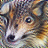
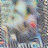
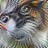
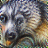
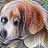
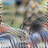
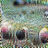
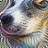
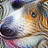
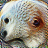
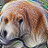
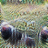
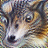
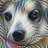
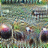
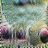


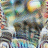
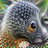
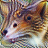
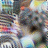
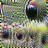
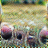
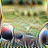
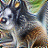
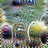
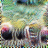
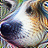
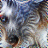
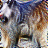
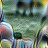
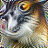
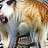


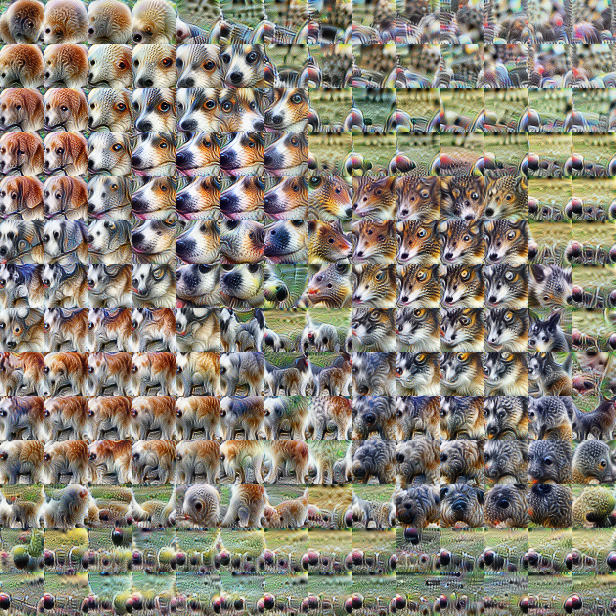

In [0]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")
_ = render_activation_grid_less_naive(img, model, W=48, n_steps=1024)